# IFT870 - Examen final

Auteur : Aurélien Vauthier (19 126 456)

In [29]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score, make_scorer, silhouette_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from scipy.spatial.distance import cdist, pdist, squareform
from itertools import combinations
from tqdm import tqdm
import numpy as np
import pandas as pd
# %matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Chargement d'un ensemble de données de faces de personnages connus
from sklearn.datasets import fetch_lfw_people

In [31]:
faces = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

In [32]:
# format des images et nombres de clusters
print("Format des images: {}".format(faces.images.shape))
print("Nombre de classes: {}".format(len(faces.target_names)))

Format des images: (3023, 87, 65)
Nombre de classes: 62


In [33]:
# nombre de données par cluster
nombres = np.bincount(faces.target)
for i, (nb, nom) in enumerate(zip(nombres, faces.target_names)):
    print("{0:25} {1:3}".format(nom, nb), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

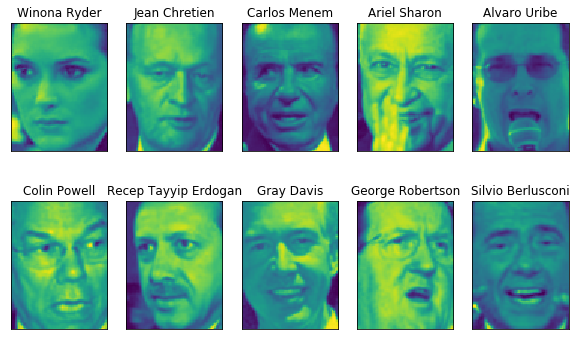

In [34]:
# Affichage des 10 premières faces
fig, axes = plt.subplots(2, 5, figsize=(10, 6),
                         subplot_kw={'xticks': (), 'yticks': ()})
for nom, image, ax in zip(faces.target, faces.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(faces.target_names[nom])

In [35]:
# Convert data array to DataFrame and append targets
data = pd.DataFrame(faces.data)
data["target"] = faces.target

# keep the first 40 data for each target
data = data.groupby("target").head(40)

# show results
data.head()

,0,1,2,3,4,5,6,7,8,9,...,5646,5647,5648,5649,5650,5651,5652,5653,5654,target
0,57.000000,60.333332,78.000000,120.666664,156.000000,178.000000,195.333328,210.666672,221.333328,222.333328,...,41.666668,17.333334,15.666667,20.000000,19.000000,18.333334,17.333334,16.666666,22.666666,61
1,66.666664,80.666664,88.666664,68.000000,63.333332,96.000000,115.333336,127.666664,139.000000,148.333328,...,25.333334,18.666666,11.666667,8.666667,8.000000,8.666667,8.666667,8.333333,9.333333,25
2,18.666666,14.333333,15.000000,13.666667,14.666667,23.333334,55.333332,92.666664,125.666664,154.666672,...,253.000000,251.333328,240.666672,172.666672,47.666668,20.666666,22.666666,22.666666,25.666666,9
3,76.666664,113.666664,172.000000,201.666672,199.333328,190.333328,177.000000,167.666672,167.666672,171.333328,...,82.000000,115.000000,131.666672,137.333328,136.666672,138.333328,140.666672,143.000000,143.333328,5
4,79.000000,70.000000,70.333336,81.666664,99.000000,126.000000,144.333328,156.666672,164.333328,168.666672,...,88.666664,91.000000,90.000000,89.666664,85.333336,83.000000,80.333336,74.000000,64.333336,1


In [38]:
pca = PCA(100, whiten=True, random_state=0)
data = pca.fit_transform(data.drop("target", axis=1))

array([[-5.72746813e-01,  1.12933946e+00, -2.53437310e-01,
         4.06829983e-01, -3.22095215e-01,  4.82811958e-01,
         7.91778922e-01,  2.61638904e+00,  9.04368699e-01,
         2.02948046e+00, -9.73057568e-01, -9.61095810e-01,
        -1.53197086e+00,  7.68880546e-01,  9.52569544e-01,
         3.54539454e-01, -4.64742571e-01,  1.23377728e+00,
         4.35334146e-01, -9.57995057e-01,  3.66766781e-01,
        -8.50497842e-01, -1.03996241e+00, -1.91104949e-01,
         1.84965158e+00,  3.15256208e-01, -8.16871747e-02,
         3.31567073e+00, -1.14764357e+00,  2.41551489e-01,
         5.85306063e-02,  1.36677361e+00, -6.24089301e-01,
        -1.27165616e-01,  1.38045418e+00, -1.13830912e+00,
        -3.19799423e-01,  2.19703168e-01, -2.15347743e+00,
        -3.19677413e-01, -7.17136741e-01, -1.66820988e-01,
         5.10566115e-01,  2.37764180e-01,  3.41389388e-01,
         2.53991127e+00, -3.54842007e-01,  8.69709373e-01,
        -2.82890260e-01,  4.35075313e-01, -9.26557779e-0

In [39]:
def robustness(clusterings):
    len_P = 0
    same_cluster_counter = 0
    n_pairs = len(list(combinations(range(clusterings.shape[0]), 2)))

    for i, j in tqdm(combinations(range(clusterings.shape[0]), 2), total=n_pairs):
        same_cluster_count = np.sum(clusterings[i] == clusterings[j])

        same_cluster_counter += same_cluster_count
        len_P += same_cluster_count > 0

    return same_cluster_counter / (len_P * clusterings.shape[1])


## Question 1 : Robustesse aux changement de paramètres d’un modèle KMeans ou AgglomerativeCLustering

*Écrivez une fonction prenant en paramètre une instance de la classe KMeans ou de la
classe AgglomerativeClustering, et retournant la robustesse de cette instance, calculée
comme suit :*

*Faire varier uniquement le paramètre n_clusters de l’instance en lui additionnant les valeurs 
`[-5,-4,-3,-2,-1,0,1,2,3,4,5]`. Pour chaque valeur du paramètre n_clusters, entraîner le modèle et
prédire un clustering. Calculer le score de robustesse R correspondant aux 11 clusterings obtenus.*

In [40]:
def n_clusters_robustness(model):
    n_clusters_modifications = range(-5, 6)
    predictions = np.zeros((data.shape[0], len(n_clusters_modifications)))

    for i, modification in tqdm(enumerate(n_clusters_modifications), total=len(n_clusters_modifications)):
        model.n_clusters += modification
        prediction = model.fit_predict(data)
        predictions[:, i] = prediction

    return robustness(predictions)


*Calculer la robustesse des modèles : KMeans(n_clusters=k, random_state=0) et
AgglomerativeClustering(n_clusters=k) pour k = 40, 60 ou 80. Quel est le modèle le plus
robuste suivant le score R ?*

In [ ]:
k_means_robustness = []
agglomerative_clustering_robustness = []

for k in range(40, 81, 20):
    kmean = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
    agglo = AgglomerativeClustering(n_clusters=k)

    k_means_robustness.append(n_clusters_robustness(kmean))
    agglomerative_clustering_robustness.append(n_clusters_robustness(agglo))

sns.heatmap([k_means_robustness, agglomerative_clustering_robustness],
            xticklabels=range(40, 81, 20), yticklabels=["KMeans", "AgglomerativeClustering"], annot=True, fmt=".0%")
plt.suptitle("Scores de robustesse pour KMeans et AgglomerativeClustering")
plt.xlabel("K")
plt.ylabel("Modèle")
plt.show()

## Question 2 : Robustesse aux changement de paramètres d’un modèle DBSCAN

*Écrivez une fonction prenant en paramètre une instance du modèle DBSCAN, et
retournant la robustesse de cette instance, calculée comme suit :*

*Faire varier uniquement le paramètre eps de l’instance en lui additionnant les valeurs 
`[-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5]`. Pour chaque valeur du paramètre eps, entraîner le
modèle et prédire un clustering. Calculer le score de robustesse R correspondant aux 11
clusterings obtenus.*

In [41]:
def eps_robustness(model):
    eps_modifications = np.arange(-0.5, 0.6, 0.1)
    predictions = np.zeros((data.shape[0], len(eps_modifications)))

    for i, modification in tqdm(enumerate(eps_modifications), total=len(eps_modifications)):
        model.eps += modification
        prediction = model.fit_predict(data)
        predictions[:, i] = prediction

    return robustness(predictions)


*Calculer la robustesse des modèles : DBSCAN(min_samples =3, eps=e) pour k = 7, 8 ou 9.
Quel est le modèle le plus robuste suivant le score R ?*

In [ ]:
dbscan_robustness = []

for eps in range(7, 10):
    dbscan = DBSCAN(min_samples=3, eps=eps, n_jobs=-1)
    dbscan_robustness.append(eps_robustness(dbscan))

sns.heatmap([dbscan_robustness], xticklabels=range(7, 10), yticklabels=["DBSCAN"], annot=True, fmt=".0%")
plt.suptitle("Scores de robustesse pour DBSCAN")
plt.xlabel("eps")
plt.ylabel("Modèle")
plt.show()

## Question 3 : Robustesse à l’ajout de bruit d’un modèle KMeans ou AgglomerativeCLustering

*Écrivez une fonction prenant en paramètres une instance de la classe KMeans ou de la
classe AgglomerativeClustering et un entier X de valeur comprise entre 0 et 100
représentant un pourcentage, et retournant la robustesse de cette instance, calculée comme
suit :*

*Générer aléatoirement 10 ensembles contenant chacun X*1960/100 données (bruit) de la
même forme que les données utilisées (5655 dimensions) suivant la loi normale N(μ, σ2) pour
chaque dimension telle que μ est la moyenne de la dimension et σ2 sa variance (utiliser
numpy.random.randn par exemple). Le 11e ensemble de bruit est vide. Faire varier les
données en leur ajoutant à chaque itération un des ensembles de bruit générés. Pour chaque
itération, entraîner le modèle et prédire un clustering. Calculer le score de robustesse R
correspondant aux 11 clusterings obtenus.*

In [42]:
def noise_generator(X):
    mu = data.mean(axis=0)
    sigma = data.var(axis=0)

    return np.random.normal(mu, sigma, (X*data.shape[0]//100, data.shape[1]))

def noise_robustness(model, X):
    predictions = np.zeros((data.shape[0], 11))

    for i in tqdm(range(10)):
        noise = noise_generator(X)
        prediction = model.fit_predict(np.concatenate((data, noise)))
        predictions[:, i] = prediction[:data.shape[0]]

    predictions[:, 10] = model.fit_predict(data)

    return robustness(predictions)


*Calculer la robustesse des modèles : KMeans(n_clusters=k, random_state=0) et
AgglomerativeClustering(n_clusters=k) pour k = 40, 60 ou 80, pour une valeur X = 5. Quel
est le modèle le plus robuste suivant le score R ?*

100%|██████████| 1834570/1834570 [00:14<00:00, 123565.32it/s]


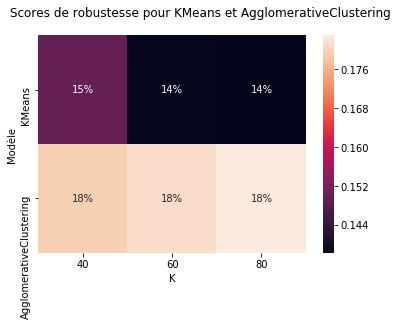

In [43]:
k_means_robustness = []
agglomerative_clustering_robustness = []
X = 5

for k in range(40, 81, 20):
    kmean = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
    agglo = AgglomerativeClustering(n_clusters=k)

    k_means_robustness.append(noise_robustness(kmean, X))
    agglomerative_clustering_robustness.append(noise_robustness(agglo, X))

sns.heatmap([k_means_robustness, agglomerative_clustering_robustness],
            xticklabels=range(40, 81, 20), yticklabels=["KMeans", "AgglomerativeClustering"], annot=True, fmt=".0%")
plt.suptitle("Scores de robustesse pour KMeans et AgglomerativeClustering")
plt.xlabel("K")
plt.ylabel("Modèle")
plt.show()

## Question 4 : Robustesse aux changement de paramètres d’un modèle DBSCAN

*Écrivez une fonction prenant en paramètre une instance du modèle DBSCAN et un
entier X de valeur comprise entre 0 et 100 représentant un pourcentage, et retournant la
robustesse de cette instance, calculée comme suit :*

*Générer aléatoirement 11 ensembles de bruit (dont 1 vide) comme indiqué à la Question 3.
Faire varier les données en leur ajoutant à chaque itération un des ensembles de bruit. Pour
chaque itération, entraîner le modèle et prédire un clustering. Calculer le score de robustesse
R correspondant aux 11 clusterings obtenus.*

*Calculer la robustesse des modèles : DBSCAN(min_samples =3, eps=e) pour k = 7, 8 ou 9,
pour une valeur X = 5. Quel est le modèle le plus robuste suivant le score R ?*

100%|██████████| 1834570/1834570 [00:14<00:00, 123118.45it/s]


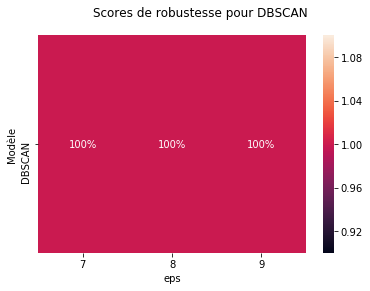

In [47]:
dbscan_robustness = []

for eps in range(7, 10):
    dbscan = DBSCAN(min_samples=3, eps=eps, n_jobs=-1)
    dbscan_robustness.append(noise_robustness(dbscan, X))

sns.heatmap([dbscan_robustness], xticklabels=range(7, 10), yticklabels=["DBSCAN"], annot=True, fmt=".0%")
plt.suptitle("Scores de robustesse pour DBSCAN")
plt.xlabel("eps")
plt.ylabel("Modèle")
plt.show()

## Question 5 : Modèle pour la génération du bruit

*Critiquez le modèle utilisé pour générer le bruit dans les Questions 3 et 4. Proposez un autre
modèle de bruit avec une justification du modèle.*